In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

import json
import time
import math
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style()

In [2]:
google_flowers = True
class_name_file = './data/class_indices.json'
train_data_path = "/media/stree/localssd/DL_data/flower_data2/train"
val_data_path = "/media/stree/localssd/DL_data/flower_data2/val"
test_data_path = "/media/stree/localssd/DL_data/flower_data2/val/"

if not google_flowers:
    class_name_file = './data/flowers_17_cat_to_name.json'
    train_data_path = "/media/stree/localssd/DL_data/flower_17/train"
    val_data_path = "/media/stree/localssd/DL_data/flower_17/val"
    test_data_path = "/media/stree/localssd/DL_data/flower_17/test/"
    
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

with open(class_name_file, 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(cat_to_name['1'])
print(cat_to_name['4'])
print()
classes, c_2_idx = find_classes(train_data_path)
print(classes)
print(c_2_idx)
print()
cls_2_name = {}

print(c_2_idx.keys())
print()
for k in c_2_idx.keys():
    cls = c_2_idx[str(k)]
    print('k: ', k, ' cls: ', cls)
    if google_flowers:
        cls_2_name[str(cls)] = cat_to_name[str(cls)]
    else:
        cls_2_name[int(cls)] = cat_to_name[str(k)]
print(cls_2_name)

{'0': 'daisy', '1': 'dandelion', '2': 'roses', '3': 'sunflowers', '4': 'tulips'}
dandelion
tulips

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])

k:  daisy  cls:  0
k:  dandelion  cls:  1
k:  roses  cls:  2
k:  sunflowers  cls:  3
k:  tulips  cls:  4
{'0': 'daisy', '1': 'dandelion', '2': 'roses', '3': 'sunflowers', '4': 'tulips'}


In [3]:
# Note transforms.ToTensor() scales input images
# to 0-1 range

data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
    
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=data_transform['train'])

val_data = torchvision.datasets.ImageFolder(root=val_data_path,
                                            transform=data_transform['val'])

batch_size=16

nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 4])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
    
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,
                                               num_workers=nw)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False,
                                              num_workers=nw)

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda:0")
        
print(device)
print(('load data ---> done!'))

Using 4 dataloader workers every process
cuda:0
load data ---> done!


In [4]:

import numpy as np
print(train_data[12][0].shape)
# ---- train_data in tuples
n = 1 
labels = [x[n] for x in train_data]
#print(labels)
print(np.unique(labels))          
num_classes = len(np.unique(labels))

print(num_classes)


torch.Size([3, 224, 224])
[0 1 2 3 4]
5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([4, 2, 0, 1, 3, 2, 4, 1, 1, 3, 0, 4, 0, 1, 1, 1])


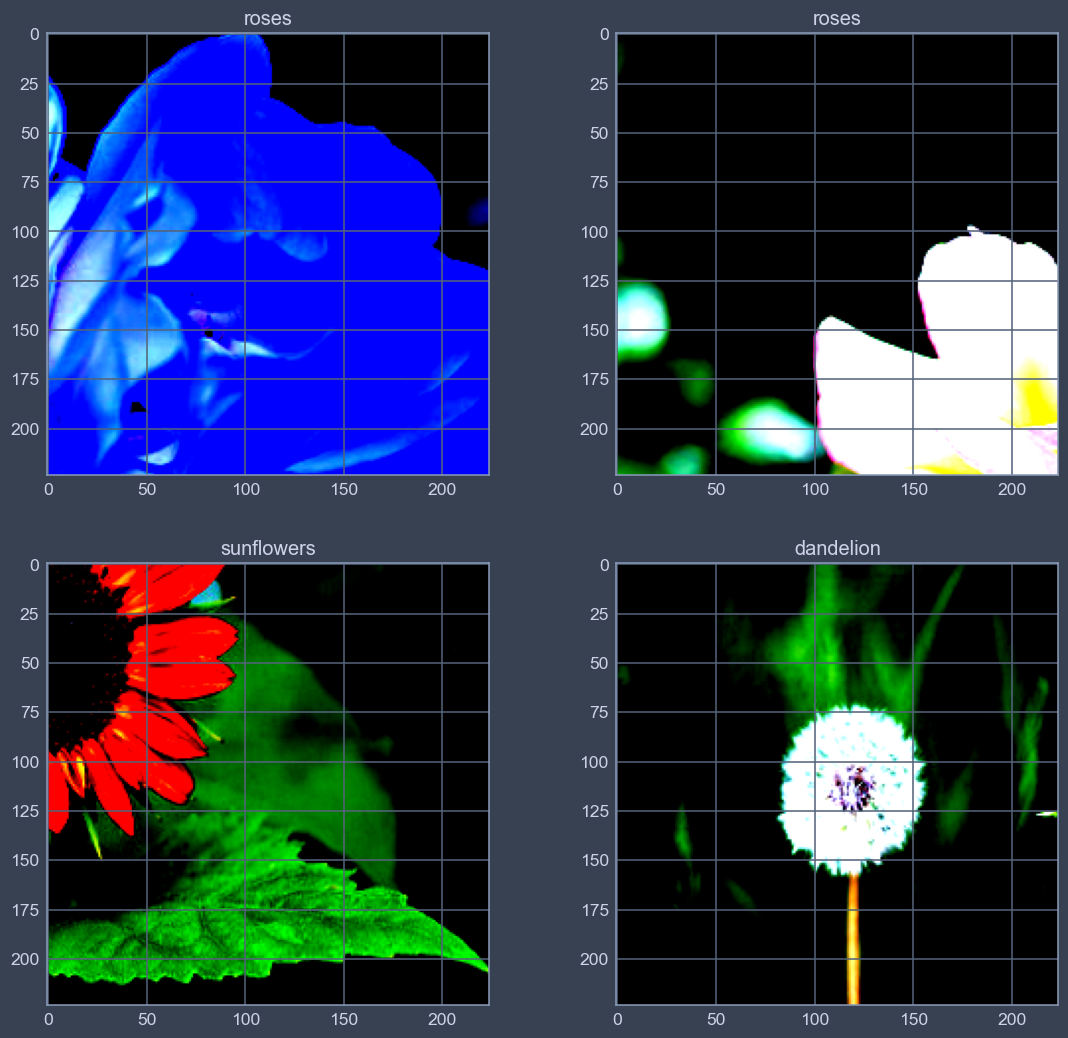

In [5]:
it = iter(train_data_loader)

dt,target = it.__next__()
print(dt[1].shape)
print(target)

# 显示图片
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
if google_flowers:
    axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
    axes[0,0].title.set_text(cls_2_name[str(target[1].numpy())])
    axes[0,1].imshow(dt[5].numpy().transpose(1, 2, 0))
    axes[0,1].title.set_text(cls_2_name[str(target[5].numpy())])
    axes[1,0].imshow(dt[9].numpy().transpose(1, 2, 0))
    axes[1,0].title.set_text(cls_2_name[str(target[9].numpy())])
    axes[1,1].imshow(dt[13].numpy().transpose(1, 2, 0))
    axes[1,1].title.set_text(cls_2_name[str(target[13].numpy())])
else:
    axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
    axes[0,0].title.set_text(cls_2_name[int(target[1].numpy())])
    axes[0,1].imshow(dt[5].numpy().transpose(1, 2, 0))
    axes[0,1].title.set_text(cls_2_name[int(target[5].numpy())])
    axes[1,0].imshow(dt[9].numpy().transpose(1, 2, 0))
    axes[1,0].title.set_text(cls_2_name[int(target[9].numpy())])
    axes[1,1].imshow(dt[13].numpy().transpose(1, 2, 0))
    axes[1,1].title.set_text(cls_2_name[int(target[13].numpy())])
plt.show()

In [6]:
################################
# network ResNet
################################

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because CIFAR is already 1x1 here:
        # disable avg pooling
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        #probas = F.softmax(logits, dim=1)
        return out



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=False)
    return model

'''
net = resnet34(num_classes)
x = torch.randn(32,3,224,224)
y = net(x)
print(y.shape)
'''

'\nnet = resnet34(num_classes)\nx = torch.randn(32,3,224,224)\ny = net(x)\nprint(y.shape)\n'

In [7]:
model = resnet34(num_classes=num_classes)
#print(model)

input = torch.randn(8,3,224,224)
out = model(input)
print(out.shape)

torch.Size([8, 5])


In [8]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device="cpu"):

    for epoch in range(epochs):
        # ---- Training ----
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        # ---- Validating ----
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {:3d},  Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.2f}'.format(
            epoch + 1, training_loss, valid_loss, num_correct / num_examples))

In [9]:
model.to(device)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.001)

### Training model

In [10]:
# Training model

train(model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,
      val_data_loader, epochs=50, device=device)

Epoch:   1,  Training Loss: 1.4470, Validation Loss: 1.2941, accuracy = 0.38
Epoch:   2,  Training Loss: 1.2691, Validation Loss: 1.0784, accuracy = 0.54
Epoch:   3,  Training Loss: 1.2102, Validation Loss: 1.5251, accuracy = 0.57
Epoch:   4,  Training Loss: 1.1360, Validation Loss: 0.8937, accuracy = 0.66
Epoch:   5,  Training Loss: 1.0982, Validation Loss: 0.9455, accuracy = 0.67
Epoch:   6,  Training Loss: 1.0540, Validation Loss: 1.0553, accuracy = 0.57
Epoch:   7,  Training Loss: 1.0114, Validation Loss: 0.9854, accuracy = 0.60
Epoch:   8,  Training Loss: 1.0050, Validation Loss: 0.9969, accuracy = 0.68
Epoch:   9,  Training Loss: 0.9688, Validation Loss: 0.8939, accuracy = 0.66
Epoch:  10,  Training Loss: 0.9583, Validation Loss: 0.8675, accuracy = 0.68
Epoch:  11,  Training Loss: 0.9400, Validation Loss: 0.8378, accuracy = 0.71
Epoch:  12,  Training Loss: 0.9123, Validation Loss: 0.8421, accuracy = 0.66
Epoch:  13,  Training Loss: 0.9073, Validation Loss: 0.7068, accuracy = 0.74

### Test

In [13]:
#test_data_path = "D:/DL_data/flower_17/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=data_transform['val'])

batch_size=16
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=nw)

loss_fn = torch.nn.CrossEntropyLoss()

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0.0

for batch in test_loader:
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    targets = targets.to(device)
    loss = loss_fn(output,targets) 
    test_loss += loss.data.item() * inputs.size(0)
    correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

print('Test Loss: {:.2f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))

Test Loss: 0.43, accuracy = 0.85


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
(3, 224, 224)
(3, 1, 1)


<Figure size 2500x3000 with 0 Axes>

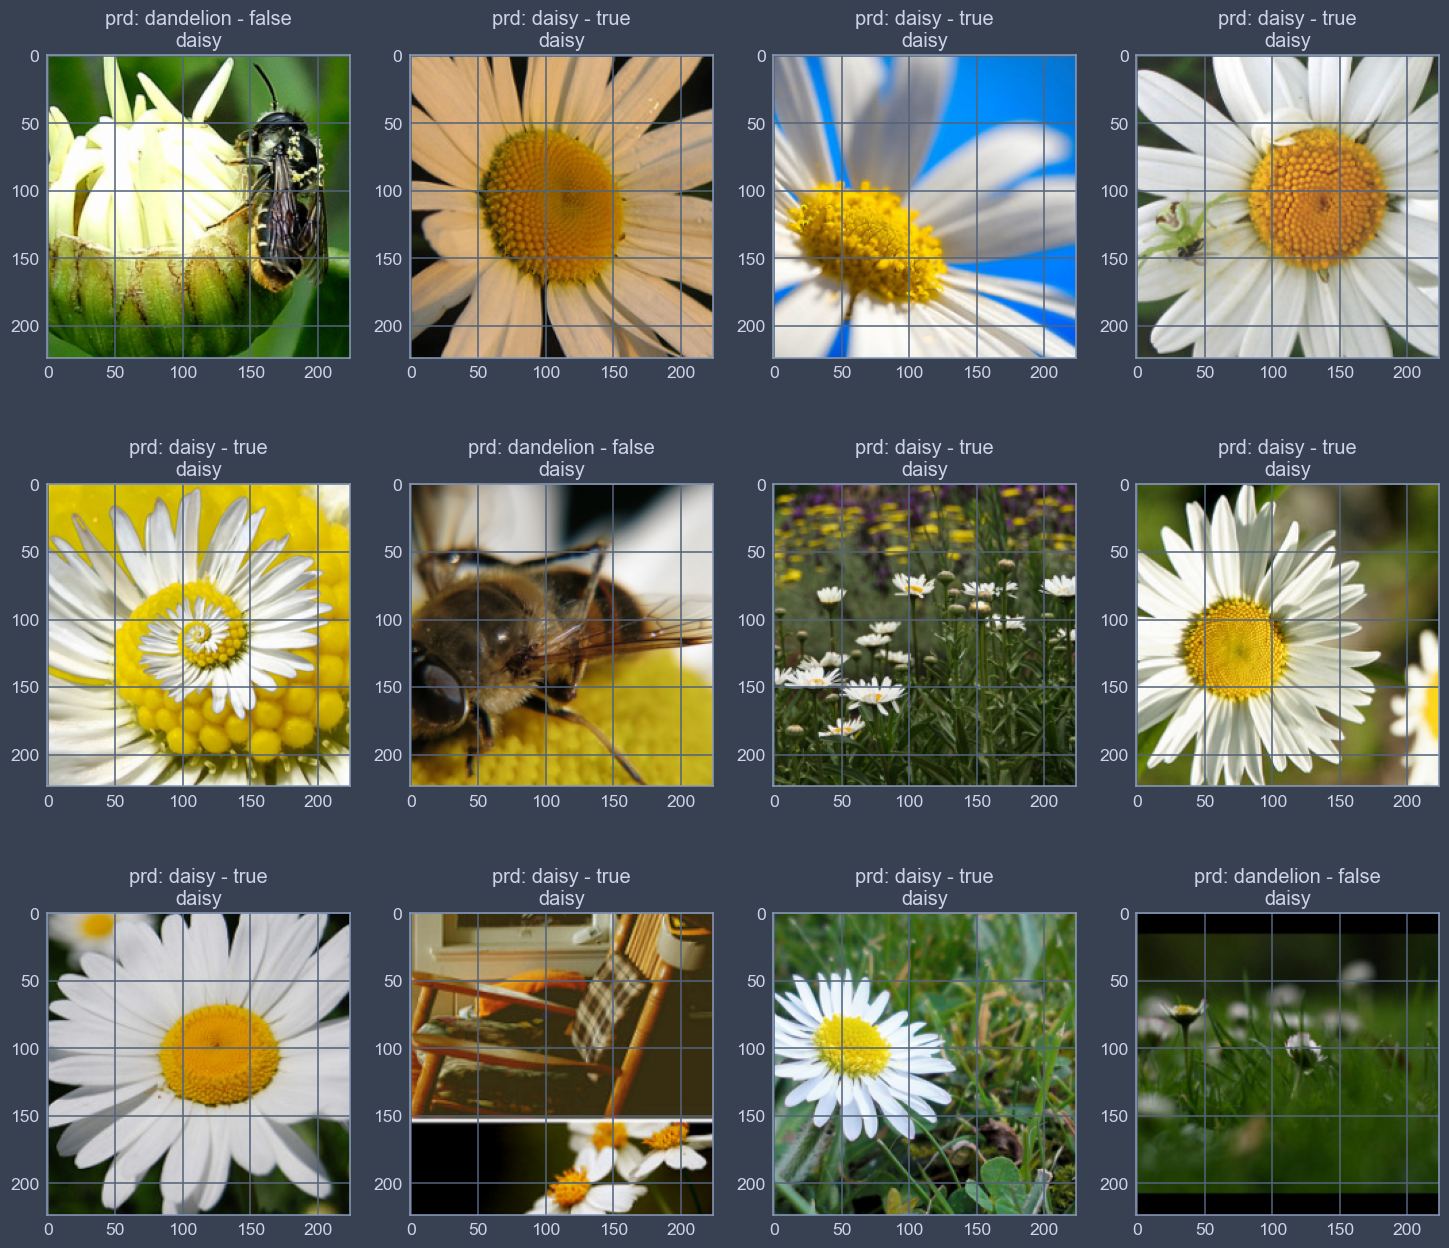

In [14]:
it = iter(test_loader)
it.__next__()
dt, labs = it.__next__()
dt = dt.to(device)
output = model(dt)
prd_labs = torch.max(F.softmax(output), dim=1)[1].view(-1)
print(labs)
print(prd_labs)

img_mean = torch.tensor([0.485, 0.456, 0.406]).reshape((3, 1, 1)).to(device)
img_std = torch.tensor([0.229, 0.224, 0.225]).reshape((3, 1, 1)).to(device)
print(dt[0].cpu().numpy().shape)
print(img_mean.cpu().numpy().shape)

plt.figure(figsize=(25,30))
row = 4
col = 3
if google_flowers:
    row = 3
    col = 4
    plt.figure(figsize=(16,15))
    
k = 0
for i in range(row):
    for j in range(col):
        if google_flowers:
            ax = plt.subplot2grid((3,4), (i,j))
        else:
            ax = plt.subplot2grid((4,5), (i,j)) 
        
        # -----------------------------------------------------------------------------------------------------------------
        # tensor denormalization
        # -----------------------------------------------------------------------------------------------------------------
        img_dt = torch.mul(dt[k], img_std) + img_mean
        img_dt = img_dt*255
        img_dt = img_dt.to(torch.uint8)
        
        if torch.cuda.is_available():
            img_dt = img_dt.cpu().numpy().transpose((1, 2, 0))
            if google_flowers:
                if int(prd_labs[k].cpu().numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].cpu().numpy())] + ' - true\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].cpu().numpy())] + ' - false\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
            else:
                if int(prd_labs[k].cpu().numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].cpu().numpy())] + ' - true\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].cpu().numpy())] + ' - false\n ' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
        else:
            img_dt = img_dt.numpy().transpose((1, 2, 0))
            if google_flowers:
                if int(prd_labs[k].numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].numpy())] + ' - true\n ' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[str(prd_labs[k].numpy())] + ' - false\n' + cls_2_name[str(labs[k].numpy())]
                    ax.imshow(img_dt)
            else:
                if int(prd_labs[k].numpy()) == int(labs[k].numpy()):
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + ' - true\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
                else:
                    tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + ' - false\n' + cls_2_name[int(labs[k].numpy())]
                    ax.imshow(img_dt)
        ax.title.set_text(tlt)
        #ax.scatter(range(20),range(20)+np.random.randint(-5,5,20))
        k = k + 1
plt.show()